In [8]:
import torch
import pandas as pd
import torchdata
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import pipeline
import seaborn
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation

In [10]:
nltk.download('stopwords')
rus_stop_words = stopwords.words("russian")
symbols = list(punctuation) + ['\t', '\n', '\r',
                               '№', '#', '@', '^', '%', '*', '»', '«', '×', 'ń', '√', 'а́']
emojy = [
    '\xeb',
    '\ufffc',
    '\xbf',
    '\u2011',
    '\u200b',
    '\u203c'
]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
emoj = re.compile('['
                  u'\U0001F600-\U0001F64F'
                  u'\U0001F300-\U0001F5FF'
                  u'\U0001F680-\U0001F6FF'
                  u'\U0001F1E0-\U0001F1FF'
                  u'\U00002500-\U00002BEF'
                  u'\U00002702-\U000027B0'
                  u'\U000024C2-\U0001F251'
                  u'\U0001f926-\U0001f937'
                  u'\U00010000-\U0010ffff'
                  u'\u2640-\u2642'
                  u'\u2600-\u2B55'
                  u'\u200d'
                  u'\u23cf'
                  u'\u23e9'
                  u'\u231a'
                  u'\ufe0f'
                  u'\u3030'
                  ']', re.UNICODE)


In [21]:
def bad_patterns_to_tags_replaser(text: str):
    text = re.sub(r'[\n\.\,\?\(\)\[\]\'\"\*\{\}\|\\\$\^\&\!\<\>\:\;«»-]', ' ', text)
    text = re.sub(r'\w+@\w?mail', ' ', text)
    text = re.sub(r'\w+@\w?mail.\w+', ' ', text)
    text = re.sub(r'\d+\:\d+\:\d+', ' ', text)
    text = re.sub(r'\d+\:\d+', ' ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' ', text)
    text = re.sub('\d+/\d+/\d+', ' ', text)
    text = re.sub('\d+-\d+-\d+', ' ', text)
    text = re.sub('\d+th', ' ', text)
    text = re.sub('\d+rd', ' ', text)
    text = re.sub('\d+st', ' ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' ', text)
    text = re.sub('\d+', ' ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    for i in emojy:
        text = text.replace(i, ' ')
    text = re.sub(emoj, ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text


In [13]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1


In [14]:
data = pd.read_csv('./train_dataset_train.csv', sep=";")
data.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу


In [15]:
theme_group_classes = {j: i for i, j in enumerate(data['Группа тем'].unique())}
theme_group_classes

{'Благоустройство': 0,
 'Социальное обслуживание и защита': 1,
 'Общественный транспорт': 2,
 'Здравоохранение/Медицина': 3,
 'Мусор/Свалки/ТКО': 4,
 'Образование': 5,
 'Дороги': 6,
 'ЖКХ': 7,
 'Коронавирус': 8,
 'Экономика и бизнес': 9,
 'Культура': 10,
 'Связь и телевидение': 11,
 'Газ и топливо': 12,
 'Безопасность': 13,
 'Спецпроекты': 14,
 'Мобилизация': 15,
 'МФЦ "Мои документы"': 16,
 'Физическая культура и спорт': 17,
 'Торговля': 18,
 'Строительство и архитектура': 19,
 'Памятники и объекты культурного наследия': 20,
 'Экология': 21,
 'Государственная собственность': 22,
 'Роспотребнадзор': 23,
 'Погребение и похоронное дело': 24,
 'Электроснабжение': 25}

In [23]:
theme_group_counts = data['Группа тем'].value_counts()
b = theme_group_counts[theme_group_counts > 250].index.to_list()
data_rem_c = data.loc[data['Группа тем'].apply(lambda a: a in b)]
name_os, system_os = RandomUnderSampler().fit_resample(data_rem_c.loc[:, ['Текст инцидента']], data_rem_c['Группа тем'])
data_os = pd.DataFrame({'Текст инцидента': name_os['Текст инцидента'].apply(lambda a: bad_patterns_to_tags_replaser(a)), 'Группа тем': system_os})
print("OS:", data_os.shape)
print("Prev:", data_rem_c.shape)
theme_group_classes = {j: i for i, j in enumerate(data_os['Группа тем'].unique())}
print(len(theme_group_classes))
data_os.head()

OS: (2990, 2)
Prev: (22077, 4)
10


,Текст инцидента,Группа тем
0,Здравствуйте когда будет обработка парков от ...,Безопасность
1,Северный ул Чернышевского Так то их в три раз...,Безопасность
2,Здравствуйте уважаемые специалисты Администра...,Безопасность
3,Началось br Во двор уже лезут вроде ещё даже ...,Безопасность
4,Почему вы не передаёте информацию в полицию,Безопасность


In [24]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(data_os['Текст инцидента'], data_os['Группа тем'], test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(data_os['Текст инцидента'], data_os['Группа тем'])


In [25]:
pd.DataFrame({'name': X_train_os, 'system': y_train_os}).to_csv('./os_dataset_train2.csv', index=False)
pd.DataFrame({'name': X_test_os, 'system': y_test_os}).to_csv('./os_dataset_test2.csv', index=False)


In [26]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
sentence_vectorizer = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [43]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    # input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    # print('->', input_mask_expanded.shape, attention_mask.shape, token_embeddings.shape)
    # sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    # sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    k = torch.cat([token_embeddings, torch.zeros(token_embeddings.shape[0], 128 - token_embeddings.shape[1], token_embeddings.shape[2])], 1)
    # print('->', k.shape)
    return k

def processing(pair):
    with torch.no_grad():
        e = tokenizer(pair[0], padding=True, truncation=True, max_length=128, return_tensors='pt')
        k = sentence_vectorizer(**e)
    return (mean_pooling(k, e['attention_mask'])[0], torch.nn.functional.one_hot(torch.tensor([theme_group_classes[pair[1]]]), len(theme_group_classes))[0])
train_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_train2.csv'])
train_pairs = torchdata.datapipes.iter.FileOpener(train_pairs, mode='r', encoding='utf-8', )
train_pairs = train_pairs.parse_csv(skip_lines=1, delimiter=',')
train_pairs = train_pairs.shuffle().map(processing)
train_dataloader = torch.utils.data.DataLoader(train_pairs, batch_size=20, shuffle=True)
print_simple_data_pipe(train_dataloader, lambda a: (a[0].shape, a[1].shape), n=1)

<class 'torch.utils.data.dataloader.DataLoader'>
(torch.Size([20, 128, 384]), torch.Size([20, 10]))
(torch.Size([20, 128, 384]), torch.Size([20, 10]))


In [28]:
class RecGRUExample(torch.nn.Module):
    def __init__(
        self,
        size_of_sample: int,
        num_of_samples: int,
        output_size_of_input_layer: int,
        output_layer_size: int,
        alpha: float = 5
    ):
        
        super(RecGRUExample, self).__init__()
        self.alpha = alpha
        self.input_size_of_input_layer = size_of_sample
        self.output_size_of_input_layer = output_size_of_input_layer
        self.num_layers_of_input_layer = int(num_of_samples / (alpha * (self.input_size_of_input_layer + self.output_size_of_input_layer)))+1
        self.output_layer_size = output_layer_size
        self.num_of_samples = num_of_samples

        self.input_layer = torch.nn.GRU(
            input_size=self.input_size_of_input_layer,
            hidden_size=self.output_size_of_input_layer,
            num_layers=self.num_layers_of_input_layer,
            # bidirectional = True
        )
        self.output_layer = torch.nn.Conv1d(
            self.num_of_samples,
            self.output_layer_size,
            self.output_size_of_input_layer,
        )

        self.input_activation = torch.nn.Tanh()
        self.h1 = torch.zeros(self.num_layers_of_input_layer, self.num_of_samples, self.output_size_of_input_layer).double().to('cuda')

    def forward(self, x):
        y, h_r = self.input_layer(x, self.h1)
        # print(y.shape)
        y = self.input_activation(y)
        y = self.output_layer(y)
        return y.view(y.shape[0], y.shape[1])


In [44]:
model_GRU = RecGRUExample(
    size_of_sample=384,
    num_of_samples=128,
    output_size_of_input_layer=50,
    output_layer_size=10,
    alpha=0.1
).double().to('cuda')


In [54]:
theme_group_classes

{'Безопасность': 0,
 'Благоустройство': 1,
 'Дороги': 2,
 'ЖКХ': 3,
 'Здравоохранение/Медицина': 4,
 'Коронавирус': 5,
 'Мусор/Свалки/ТКО': 6,
 'Образование': 7,
 'Общественный транспорт': 8,
 'Социальное обслуживание и защита': 9}

In [45]:
model_GRU.num_layers_of_input_layer

3

In [46]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.005)
er_list_gru = []

In [48]:
epochs = 20
for epoch in range(epochs):
    t = 1
    for x_b, y_b in train_dataloader:
        outputs = model_GRU(x_b.double().to('cuda'))
        loss_value = loss(outputs, y_b.double().to('cuda'))
        loss_value.backward(retain_graph=True)
        # if len(er_list) > 3:
            # if abs(er_list[-1] - er_list[-2]) < 0.001 and er_list[-1] < 10:
            #     optimizer = torch.optim.Adam(model_GRU.parameters(), lr=100)
            # else:
            #     optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.0001)
        optimizer.step()
        optimizer.zero_grad()
        if t:
            t = 0
            print('suc')
    er_list_gru.append(loss_value.item())
    print(f'Эпоха {epoch + 1}, Значение функции потерь: {loss_value.item()}')


suc
Эпоха 1, Значение функции потерь: 0.22436263403475812
suc
Эпоха 2, Значение функции потерь: 0.012425189102480732
suc
Эпоха 3, Значение функции потерь: 0.10237845981771794
suc
Эпоха 4, Значение функции потерь: 0.049423749715967275
suc
Эпоха 5, Значение функции потерь: 0.07433472736685341
suc
Эпоха 6, Значение функции потерь: 0.3187747535281074
suc
Эпоха 7, Значение функции потерь: 0.0792147824245882
suc
Эпоха 8, Значение функции потерь: 0.004434404969355686
suc
Эпоха 9, Значение функции потерь: 0.16082746786502564
suc
Эпоха 10, Значение функции потерь: 0.17035207662857044
suc
Эпоха 11, Значение функции потерь: 0.05852205745516579
suc
Эпоха 12, Значение функции потерь: 0.19488842762085054
suc
Эпоха 13, Значение функции потерь: 0.3864144715513986
suc
Эпоха 14, Значение функции потерь: 0.026218979582144464
suc
Эпоха 15, Значение функции потерь: 0.030540055013419994
suc
Эпоха 16, Значение функции потерь: 0.03562364882268149
suc
Эпоха 17, Значение функции потерь: 0.00113021402601493
suc


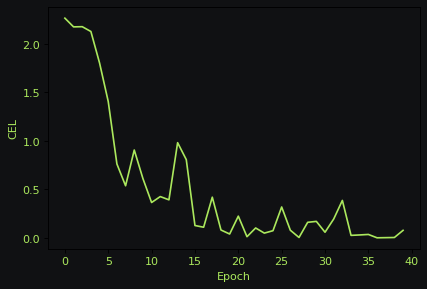

In [66]:
import matplotlib.pyplot as plt
fig = plt.figure(num=None, dpi=80, facecolor='#101113', edgecolor='#ABE85D')
plt.axes().set_facecolor('#101113')
plt.xticks(color="#ABE85D")
plt.yticks(color="#ABE85D")
plt.ylabel('CEL', color="#ABE85D")
plt.xlabel('Epoch', color="#ABE85D")
plt.plot(er_list_gru, color='#ABE85D')

In [49]:
test_pairs = torchdata.datapipes.iter.IterableWrapper(['./os_dataset_test2.csv'])
test_pairs = torchdata.datapipes.iter.FileOpener(test_pairs, mode='r', encoding='utf-8', )
test_pairs = test_pairs.parse_csv(skip_lines=1, delimiter=',')
test_pairs = test_pairs.map(processing)
test_dataloader = torch.utils.data.DataLoader(test_pairs, batch_size=1)
print_simple_data_pipe(test_dataloader, lambda a: (a[0].shape, a[1].shape), n=1)
t_y = []
r_y = []
for i, j in test_dataloader:
    r = model_GRU(i.double().to('cuda'))
    # print(r)
    # break
    r_y.append(torch.argmax(r[0]).item())
    t_y.append(torch.argmax(j).item())

<class 'torch.utils.data.dataloader.DataLoader'>
(torch.Size([1, 128, 384]), torch.Size([1, 10]))
(torch.Size([1, 128, 384]), torch.Size([1, 10]))


In [50]:
print(classification_report(t_y, r_y))

              precision    recall  f1-score   support

           0       0.24      0.23      0.24        26
           1       0.30      0.23      0.26        31
           2       0.31      0.20      0.24        25
           3       0.19      0.16      0.17        32
           4       0.19      0.25      0.22        32
           5       0.11      0.17      0.14        29
           6       0.10      0.13      0.11        39
           7       0.23      0.22      0.23        32
           8       0.30      0.21      0.24        29
           9       0.21      0.21      0.21        24

    accuracy                           0.20       299
   macro avg       0.22      0.20      0.21       299
weighted avg       0.21      0.20      0.20       299



<Axes: >

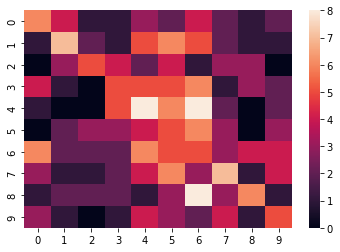

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn
seaborn.heatmap(confusion_matrix(t_y, r_y))

In [53]:
torch.save(model_GRU, './my_model_gru_group_theme.bin')